Import libraries


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle

Load dataset

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/Sayan2509/Productivity-Prediction-of-Garment-Employees/refs/heads/main/garments_worker_productivity.csv")
df = df.drop(columns=['wip'])
df.head(10)


,date,quarter,department,day,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1920,50,0.0,0,0,56.0,0.800382
5,1/1/2015,Quarter1,sweing,Thursday,7,0.80,25.90,6720,38,0.0,0,0,56.0,0.800125
6,1/1/2015,Quarter1,finishing,Thursday,2,0.75,3.94,960,0,0.0,0,0,8.0,0.755167
7,1/1/2015,Quarter1,sweing,Thursday,3,0.75,28.08,6900,45,0.0,0,0,57.5,0.753683
8,1/1/2015,Quarter1,sweing,Thursday,2,0.75,19.87,6000,34,0.0,0,0,55.0,0.753098
9,1/1/2015,Quarter1,sweing,Thursday,1,0.75,28.08,6900,45,0.0,0,0,57.5,0.750428


Correlation heatmap

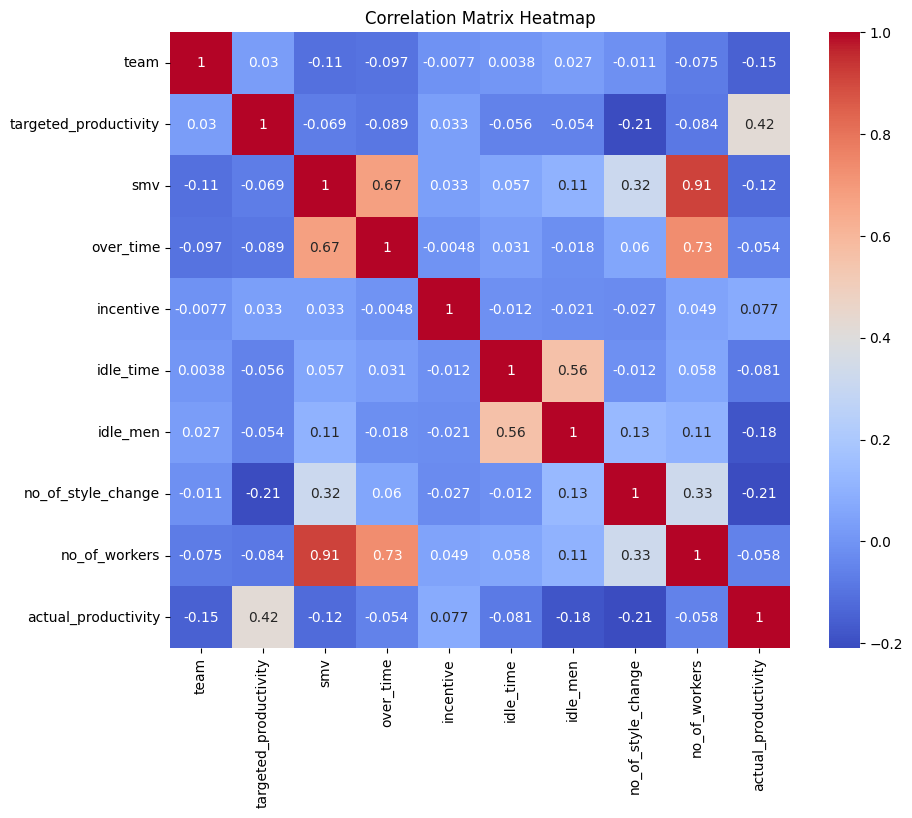

In [3]:
numeric_df = df.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix Heatmap")
plt.show()

Describe data

In [4]:
df.describe()


,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
std,3.463963,0.097891,10.943219,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488
min,1.000000,0.070000,2.900000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,6.000000,0.750000,15.260000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,9.000000,0.800000,24.260000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,12.000000,0.800000,54.560000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


 Check missing values

In [5]:
null_values = df.isnull().sum()
print(null_values)

date                     0
quarter                  0
department               0
day                      0
team                     0
targeted_productivity    0
smv                      0
over_time                0
incentive                0
idle_time                0
idle_men                 0
no_of_style_change       0
no_of_workers            0
actual_productivity      0
dtype: int64


 Convert date & extract month

In [6]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['month'] = df['date'].dt.month
print(df.columns)

Index(['date', 'quarter', 'department', 'day', 'team', 'targeted_productivity',
       'smv', 'over_time', 'incentive', 'idle_time', 'idle_men',
       'no_of_style_change', 'no_of_workers', 'actual_productivity', 'month'],
      dtype='object')


Clean department names

In [7]:
df['department'] = df['department'].str.strip().str.lower()
df['department'] = df['department'].replace({'finishing  ': 'finishing', 'sweing': 'sewing'})


Drop date column

In [8]:
df = df.drop(columns=['date'])
print(df.head())


    quarter department       day  team  targeted_productivity    smv  \
0  Quarter1     sewing  Thursday     8                   0.80  26.16   
1  Quarter1  finishing  Thursday     1                   0.75   3.94   
2  Quarter1     sewing  Thursday    11                   0.80  11.41   
3  Quarter1     sewing  Thursday    12                   0.80  11.41   
4  Quarter1     sewing  Thursday     6                   0.80  25.90   

   over_time  incentive  idle_time  idle_men  no_of_style_change  \
0       7080         98        0.0         0                   0   
1        960          0        0.0         0                   0   
2       3660         50        0.0         0                   0   
3       3660         50        0.0         0                   0   
4       1920         50        0.0         0                   0   

   no_of_workers  actual_productivity  month  
0           59.0             0.940725      1  
1            8.0             0.886500      1  
2           30.5 

MultiColumn Label Encoder

In [9]:
class MultiColumnLabelEncoder:
    def __init__(self, columns=None):
        self.columns = columns
        self.encoders = {}

    def fit_transform(self, X):
        if self.columns is not None:
            for col in self.columns:
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col])
                self.encoders[col] = le
        return X

Define categorical columns

In [10]:
categorical_columns = ['quarter', 'department', 'day']

Encode categorical data

In [11]:
encoder = MultiColumnLabelEncoder(columns=categorical_columns)
df = encoder.fit_transform(df)
print(df.head())


   quarter  department  day  team  targeted_productivity    smv  over_time  \
0        0           1    3     8                   0.80  26.16       7080   
1        0           0    3     1                   0.75   3.94        960   
2        0           1    3    11                   0.80  11.41       3660   
3        0           1    3    12                   0.80  11.41       3660   
4        0           1    3     6                   0.80  25.90       1920   

   incentive  idle_time  idle_men  no_of_style_change  no_of_workers  \
0         98        0.0         0                   0           59.0   
1          0        0.0         0                   0            8.0   
2         50        0.0         0                   0           30.5   
3         50        0.0         0                   0           30.5   
4         50        0.0         0                   0           56.0   

   actual_productivity  month  
0             0.940725      1  
1             0.886500      1  
2 

Split data

In [12]:
df.fillna(df.mean(), inplace=True)
X = df.drop(columns=['actual_productivity'])
y = df['actual_productivity']
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2, random_state=42)



 Linear Regression

In [13]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
pred_test = model_lr.predict(X_test)

mae = mean_absolute_error(y_test, pred_test)
mse = mean_squared_error(y_test, pred_test)
r2 = r2_score(y_test, pred_test)

Random Forest


In [14]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, pred_rf)
mse_rf = mean_squared_error(y_test, pred_rf)
r2_rf = r2_score(y_test, pred_rf)

XGBoost


In [15]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model_xgb.fit(X_train, y_train)
pred_xgb = model_xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, pred_xgb)
mse_xgb = mean_squared_error(y_test, pred_xgb)
r2_xgb = r2_score(y_test, pred_xgb)

Model performance comparison

In [16]:
model_performance = {
    "Linear Regression": {"MAE": mae, "MSE": mse, "R² Score": r2},
    "Random Forest": {"MAE": mae_rf, "MSE": mse_rf, "R² Score": r2_rf},
    "XGBoost": {"MAE": mae_xgb, "MSE": mse_xgb, "R² Score": r2_xgb},
}

print("\n📊 Model Performance Comparison:")
print(pd.DataFrame(model_performance).T)



📊 Model Performance Comparison:
                        MAE       MSE  R² Score
Linear Regression  0.107513  0.021423  0.193193
Random Forest      0.067031  0.011831  0.554428
XGBoost            0.073991  0.014630  0.449034


Choose best model

In [17]:
best_model_name = max(model_performance, key=lambda k: model_performance[k]["R² Score"])
best_model = {"Linear Regression": model_lr, "Random Forest": model_rf, "XGBoost": model_xgb}[best_model_name]

print(f"\n✅ Best Model Selected: {best_model_name}")



✅ Best Model Selected: Random Forest


 Save best model

In [18]:
model_filename = "best_model.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)
print("✅ Model saved as best_model.pkl")

✅ Model saved as best_model.pkl


 Save encoder & features

In [19]:
feature_columns = [c for c in df.columns if c != 'actual_productivity']
pickle.dump(encoder, open('encoder.pkl', 'wb'))
pickle.dump(feature_columns, open('feature_columns.pkl', 'wb'))
print("✅ Saved encoder.pkl and feature_columns.pkl")

✅ Saved encoder.pkl and feature_columns.pkl


 Sample predictions

In [20]:
predicted = best_model.predict(X_test[:5])
print("\n🔮 Sample Predictions:")
for i, val in enumerate(predicted):
    print(f"Employee {i+1}: Predicted Productivity = {val:.2f}")


🔮 Sample Predictions:
Employee 1: Predicted Productivity = 0.44
Employee 2: Predicted Productivity = 0.80
Employee 3: Predicted Productivity = 0.67
Employee 4: Predicted Productivity = 0.58
Employee 5: Predicted Productivity = 0.59


Plot actual vs predicted

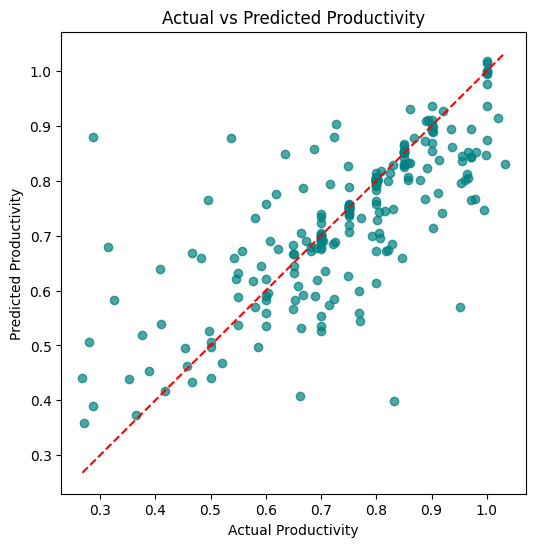

In [21]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, best_model.predict(X_test), alpha=0.7, color='teal')
plt.xlabel("Actual Productivity")
plt.ylabel("Predicted Productivity")
plt.title("Actual vs Predicted Productivity")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

Flask Web App + ngrok setup

In [ ]:
# ✅ Install required packages (skip if already installed)
!pip install flask pyngrok --quiet

# ✅ Flask App for 13 Input Features
from flask import Flask, render_template_string, request
from pyngrok import ngrok
import pickle
import numpy as np

# ✅ Load your saved model
model = pickle.load(open("best_model.pkl", "rb"))

# ✅ Initialize Flask app
app = Flask(__name__)

# 🌈 Beautiful HTML + CSS + 13 Inputs
HTML_PAGE = """
<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="UTF-8">
<meta name="viewport" content="width=device-width, initial-scale=1.0">
<title>Employee Performance Predictor</title>
<style>
body {
    font-family: 'Poppins', sans-serif;
    background: linear-gradient(120deg, #00c6ff, #0072ff);
    color: #fff;
    text-align: center;
    margin: 0;
    padding: 0;
}
header {
    background: rgba(255,255,255,0.15);
    padding: 20px;
}
h1 {
    color: #ffeb3b;
    font-size: 36px;
}
form {
    background: rgba(255,255,255,0.15);
    backdrop-filter: blur(8px);
    border-radius: 15px;
    padding: 30px;
    width: 380px;
    margin: 30px auto;
    box-shadow: 0 8px 20px rgba(0,0,0,0.3);
}
input {
    width: 90%;
    padding: 10px;
    margin: 8px 0;
    border-radius: 8px;
    border: none;
    text-align: center;
}
button {
    background: linear-gradient(90deg, #ff512f, #dd2476);
    border: none;
    padding: 10px 25px;
    border-radius: 8px;
    color: white;
    font-size: 18px;
    cursor: pointer;
    transition: 0.3s;
}
button:hover {
    transform: scale(1.05);
}
.result {
    font-size: 24px;
    color: #00ff88;
    margin-top: 20px;
    font-weight: bold;
}
footer {
    margin-top: 40px;
    font-size: 14px;
    opacity: 0.8;
}
</style>
</head>
<body>
<header>
    <h1>Employee Performance Predictor</h1>
    <p>Predict employee productivity using Machine Learning</p>
</header>

<form action="/predict" method="post">
    <input type="number" step="any" name="quarter" placeholder="Quarter (Encoded)" required><br>
    <input type="number" step="any" name="department" placeholder="Department (Encoded)" required><br>
    <input type="number" step="any" name="day" placeholder="Day (Encoded)" required><br>
    <input type="number" step="any" name="team" placeholder="Team" required><br>
    <input type="number" step="any" name="targeted_productivity" placeholder="Targeted Productivity" required><br>
    <input type="number" step="any" name="smv" placeholder="SMV" required><br>
    <input type="number" step="any" name="over_time" placeholder="Over Time" required><br>
    <input type="number" step="any" name="incentive" placeholder="Incentive" required><br>
    <input type="number" step="any" name="idle_time" placeholder="Idle Time" required><br>
    <input type="number" step="any" name="idle_men" placeholder="Idle Men" required><br>
    <input type="number" step="any" name="no_of_style_change" placeholder="No. of Style Change" required><br>
    <input type="number" step="any" name="no_of_workers" placeholder="No. of Workers" required><br>
    <input type="number" step="any" name="month" placeholder="Month" required><br>
    <button type="submit">Predict</button>
</form>

{% if result %}
<div class="result">Predicted Productivity: {{ result }}</div>
{% endif %}

<footer>© 2025 Machine Learning Project | Employee Performance Prediction</footer>
</body>
</html>
"""

# ✅ Home route
@app.route("/", methods=["GET"])
def home():
    return render_template_string(HTML_PAGE)

# ✅ Predict route
@app.route("/predict", methods=["POST"])
def predict():
    try:
        # Get all 13 inputs in correct order
        features = [
            float(request.form['quarter']),
            float(request.form['department']),
            float(request.form['day']),
            float(request.form['team']),
            float(request.form['targeted_productivity']),
            float(request.form['smv']),
            float(request.form['over_time']),
            float(request.form['incentive']),
            float(request.form['idle_time']),
            float(request.form['idle_men']),
            float(request.form['no_of_style_change']),
            float(request.form['no_of_workers']),
            float(request.form['month'])
        ]

        # Predict using loaded model
        prediction = model.predict([features])[0]
        return render_template_string(HTML_PAGE, result=round(prediction, 3))
    except Exception as e:
        return render_template_string(HTML_PAGE, result=f"⚠️ Error: {str(e)}")

# ✅ Run Flask + ngrok
ngrok.set_auth_token("33g1AGXIxmCKteCRJmyBS7YF8RE_2ju4jMofL7Vncjg2mYJn6")  # Replace with your token
public_url = ngrok.connect(5000)
print("🌍 Your custom web app is live at:", public_url)
app.run(host="0.0.0.0", port=5000)


🌍 Your custom web app is live at: NgrokTunnel: "https://superambitious-stethoscoped-isela.ngrok-free.dev" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [06/Oct/2025 12:40:59] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [06/Oct/2025 12:43:00] "POST /predict HTTP/1.1" 200 -
